In [1]:
import pandas as pd
import FIRM.base.operators.implications as implications
import FIRM.base.operators.tnorms as tnorms
import FIRM.base.fuzzy_data as fuzzy_data
from FIRM.methods.AARFI import AARFI

In [2]:
impl_operators = [implications.ImplicationsExamples.get_fuzzy_implication(implications.ImplicationsExamples.IGNORE),
                  implications.ImplicationsExamples.get_fuzzy_implication(implications.ImplicationsExamples.LUKASIEWICZ),
                  lambda x, y: 1 - x + x * (y**0.1),
                  lambda x, y: implications.ImplicationsExamples.get_fuzzy_implication(implications.ImplicationsExamples.KSS)(x, y, float(-10))]
tnorms_operators = [tnorms.TnormsExamples.get_tnorm(tnorms.TnormsExamples.PRODUCT),
                    tnorms.TnormsExamples.get_tnorm(tnorms.TnormsExamples.LUKASIEWICZ),
                    lambda x, y: np.maximum(x + y - 1, 0),
                    lambda x, y: tnorms.TnormsExamples.get_tnorm(tnorms.TnormsExamples.SCHWEIZER_SKLAR)(x, y,float(-10))]

In [3]:
def process_df(df):
    for col in df.columns:
        unique_values = df[col].dropna().unique()  # Get unique values, excluding NaN
        if len(unique_values) < 15:
            df[col] = df[col].astype('object')  # Convert to boolean
        else:
            df[col] = df[col].astype('float64')  # Convert to categorical for other binary cases
    return df

In [4]:
datasets = ['abalone.csv','iris.csv','wdbc.csv','magic.csv','vehicle.csv']

In [5]:
import csv
import pandas as pd
import numpy as np

n_datasets = len(datasets)
n_operators = len(impl_operators)

results = [[0 for _ in range(n_datasets)] for _ in range(n_operators)]

# Open a CSV file to write the results
with open('results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Operator', 'Dataset', 'Num Rules', 'Fcoverage', 'Fsupport', 'Fconfidence','FWRAcc'])

    for idx_op in range(n_operators):
        print('Operator: ' + str(idx_op))
        I = impl_operators[idx_op]
        T = tnorms_operators[idx_op]
        for idx_dat in range(n_datasets):
            print('Dataset: ' + str(datasets[idx_dat]))
            name_dataset = datasets[idx_dat]
            dataset = process_df(pd.read_csv('../assets/' + name_dataset, sep=','))
            fuzzy_dataset = fuzzy_data.FuzzyDataQuantiles(name_dataset, dataset, 3, ['L', 'M', 'H'])
            rules = AARFI(dataset, fuzzy_dataset, T, I, min_cov=0.3, min_supp=0.3, min_conf=0.8, max_feat=3)
            measures = rules.measures(fuzzy_dataset)
            
            # Extract measures
            num_rules = len(measures['num_features'])
            fcoverage = np.mean(measures['fcoverage'])
            fsupport = np.mean(measures['fsupport'])
            fconfidence = np.mean(measures['fconfidence'])
            fwracc = np.mean(measures['fwracc'])
            
            print('num rules: ' + str(len(measures['num_features'])))
            print('fcoverage: ' + str(np.mean(measures['fcoverage'])))
            print('fsupport: ' + str(np.mean(measures['fsupport'])))
            print('fconfidence: ' + str(np.mean(measures['fconfidence'])))
            print('fwracc: ' + str(np.mean(measures['fwracc'])))
            
            # Write the results to the CSV file
            writer.writerow([idx_op, name_dataset, num_rules, fcoverage, fsupport, fconfidence,fwracc])
            
            # Store the rule list in the results matrix
            results[idx_op][idx_dat] = rules.rule_list

print("Results have been saved to 'results.csv'")

Operator: 0
Dataset: abalone.csv
num rules: 101
fcoverage: 0.3583913673248563
fsupport: 0.3122656561869071
fconfidence: 0.8736697414620543
fwracc: 0.1777652859914854
Dataset: iris.csv
num rules: 17
fcoverage: 0.35057424666836434
fsupport: 0.32078553603259485
fconfidence: 0.9178793569567691
fwracc: 0.1967642859972272
Dataset: wdbc.csv
num rules: 342
fcoverage: 0.3502619435547756
fsupport: 0.31752349741179076
fconfidence: 0.9090910597895252
fwracc: 0.1679303469374531
Dataset: magic.csv
num rules: 7
fcoverage: 0.37447973216803815
fsupport: 0.3213478144912463
fconfidence: 0.8579584731072055
fwracc: 0.1667096775570054
Dataset: vehicle.csv
num rules: 56
fcoverage: 0.354104989108177
fsupport: 0.3116767045548163
fconfidence: 0.8823700414067849
fwracc: 0.18191246301419822
Operator: 1
Dataset: abalone.csv
num rules: 117
fcoverage: 0.35397371504200564
fsupport: 0.3232241562667468
fconfidence: 0.9171329851432778
fwracc: 0.19032041544496398
Dataset: iris.csv
num rules: 19
fcoverage: 0.3535389990126

In [6]:
from FIRM.base.ct_set_fuzzy_rules import SetFuzzyRules

In [7]:
M = np.ones((n_operators, n_operators))
for i in range(0, n_operators):
    for j in range(i + 1, n_operators):
        diss_perc = []
        for d in range(0, n_datasets):
            rules1 = SetFuzzyRules(results[i][d][:]) 
            rules2 = SetFuzzyRules(results[j][d][:])
            diss_perc = diss_perc + [rules1.jaccard_similarity(rules2)]
        M[i][j] = round(np.mean(diss_perc),3)

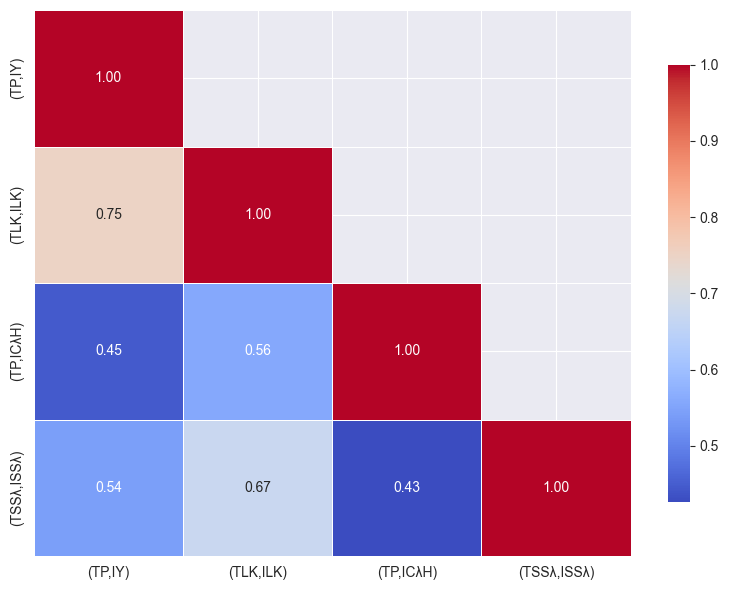

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data from the table
data = {
    "(TP,IY)": M[0],
    "(TLK,ILK)": M[1],
    "(TP,ICλH)": M[2],
    "(TSSλ,ISSλ)": M[3]
}

# Row labels
index = ["(TP,IY)", "(TLK,ILK)", "(TP,ICλH)", "(TSSλ,ISSλ)"]

# Create a DataFrame
df = pd.DataFrame(data, index=index)

# Mask the upper triangle to show only non-redundant values
mask = np.triu(np.ones_like(df, dtype=bool), k=1)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    df,
    annot=True,
    cmap="coolwarm",  # Brighter colormap (options: "viridis", "plasma", "magma", "inferno")
    fmt=".2f",  # Display two decimal places
    linewidths=0.5,
    mask=mask,  # Apply the mask to hide the upper triangle
    cbar_kws={"shrink": 0.8}
)

# Show the plot
plt.tight_layout()
plt.show()